попытка построения аппроксимации провода по ТЛС и твум точкам крепления

In [1]:
from pathlib import Path
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
p = Path(r'D:\python\some_tools\wire')

In [3]:
ts_appr = []   # approx from TS
pts = []   # LiDAR points

In [4]:
# load TS appr
with (p/'appr_ts.txt').open() as f:
        spamreader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            ts_appr.append(row)
ts_appr = np.array(ts_appr)
ts_appr[5]

array([1.48667320e+06, 5.37554638e+06, 3.37910000e+01])

In [5]:
# load LiDAR points
with (p/'1wire.xyz').open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            pts.append(row)
pts = np.array(pts)
pts[5]

array([1.48656137e+06, 5.37551805e+06, 3.38900000e+01])

In [6]:
tk1 = [ts_appr[0][0], ts_appr[0][1]]
tk2 = [ts_appr[-1][0], ts_appr[-1][1]]

In [7]:
# 1 - moving coords to the start point
def move(arr, pt):
    x, y = pt
    arr_moved = np.copy(arr)
    arr_moved[:,0]=arr_moved[:,0] - x
    arr_moved[:,1]=arr_moved[:,1] - y
    
    return arr_moved


In [8]:
# 2 - находим угол (rad)
 
def getAngle(a, b, c):
    ang = (math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    #return ang + 360 if ang < 0 else ang
    return ang
 
#ang = getAngle(tk3, tk1, tk2)

In [9]:
# 3 - теперь поворачиваем
def rotate(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = xy
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [10]:
def move_and_rotate(arr, tk1, tk2):
    tk3 = [tk1[0], tk2[1]]
    arr_moved = move(arr, tk1)
    ang = getAngle(tk3, tk1, tk2)
    
    arr_2d = []
    for i in range(len(arr_moved)):
        po = [arr_moved[i][0], arr_moved[i][1]]
        arr_2d.append([rotate(po, ang)[1], arr_moved[i][2]])  # поворот (Y) и высота от Z 
        # X выбрасываем, т.к. считаем его равным 0

    return np.array(arr_2d)

In [11]:
ts_appr_r = move_and_rotate(ts_appr, tk1, tk2)
pts_r = move_and_rotate(pts, tk1, tk2)

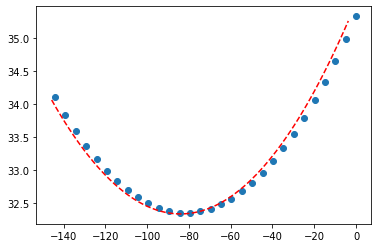

In [12]:
ff = np.arange(-61.7, 81.1, 2)
a = 1100
def z(f):
    zz = []
    for i in f:
        zz.append(a*math.cosh(i/a)-a+32.33)
    return zz

#plt.plot(pts_r[:,0], pts_r[:,1], 'o')
plt.plot(ts_appr_r[:,0], ts_appr_r[:,1], 'o')
plt.plot(ff-84, z(ff), 'r--')


dy/dx = s/a где s - длина провода   
отсюда s = a * dy / dx   
a = s * dx / dy

In [13]:
s = 1100 * (35.334 - 34.103) / 144
s

9.403472222222234

In [14]:
144/81.7

1.762545899632803

In [15]:
(35.334-32.33)/((35.334-32.33)-1.231)

1.694303440496332

In [16]:
s = a*math.sinh(144/a)  # length
s

144.41164512575577

In [17]:
lll = a*math.cosh(144/a)-a   # похоже на стрелу провеса ??
lll

9.438922720817118

In [18]:
(144**2+1.23**2)**(1/2)  # длина по прямой между ТК

144.0052530291864

итак, основная формула получается:    
    <b> a * math.cosh((x-d)/a) - a + z_min </b>   
    a - коэфф кривой  
    x - расстояние по x от нижней точки  
    d - сдвиг по оси от начала до перегиба  
    z_min - абсолютная высота нижней точки   

тут надо понимать что начало координат находится в нижней точке - в точке перегиба кривой


 - - - - - - - - - - - - - - -     
 попробуем определить высоты конечных точек получаемой аппроксимации

In [19]:
st_p, end_p = ts_appr_r[0], ts_appr_r[-1]  # start and end points
st_p, end_p

(array([ 0.   , 35.334]), array([-144.07200006,   34.103     ]))

In [20]:
# еще раз определим функцию
def curve(x, a, zmin):
    y = a*math.cosh(x/a)-a+zmin
    return y


In [21]:
curve(72, 100, 32.349)

59.408273330192976

идея такая - возьмем середину пролета как начало и усредним высоты ТК, для такого состояния найдем подходящий коэффицент а, такой чтобы у был равен усредненной высоте. далее будем сдвигать центр и тк, и смотреть как ложится на них кривая. 

In [22]:
# находим предварительный уровень кривой

def fit_cur(tk1, tk2, arr):
    def curve(x, a, zmin):
        y = a*math.cosh(x/a)-a+zmin
        return y
    
    zmin = min(arr[:,1])
    x_ini = (tk1[0]+tk2[0])/2
    z_ini = (tk1[1]+tk2[1])/2
    d = 0.05   # разница которой достаточно чтобы остановить подбор
    z = 0
    a = a2 = 10000   
    a1 = 1
    iter_ = 0
    z_d = z_ini - curve(x_ini, a, zmin)
    print(z_d)
    while abs(z_d) > d:
        if curve(x_ini, a, zmin) < z_ini:
            a2 = a
            a = (a2 - a1)/2
            iter_ +=1
            print(a, a1, a2, iter_)
        else:
            a1 = a
            a = (a2 + a1)/2
            iter_ +=1
            print(a, a1, a2, iter_)
        z_d = z_ini - curve(x_ini, a, zmin)
        print(z_d)
    
    return a

In [23]:
fit_cur(st_p, end_p, ts_appr_r)

2.1100396130143437
4999.5 1 10000 1
1.850520594321317
2499.25 1 4999.5 2
1.331279621743981
1249.125 1 2499.25 3
0.2917961620494154
624.0625 1 1249.125 4
-1.7927030616243727
936.59375 624.0625 1249.125 5
-0.4021092955381462
1092.859375 936.59375 1249.125 6
-0.005491936502728834


1092.859375

In [24]:
st_p, end_p

(array([ 0.   , 35.334]), array([-144.07200006,   34.103     ]))

In [25]:
# выравниваем по оси Х

xl, xr = end_p[0], 0
mp = (xl + xr)/2
lz_ok = 34.1
rz_ok = 35.33
dl = lz_ok - curve((end_p[0]-mp), 1092, 32.349)
dr = rz_ok - curve((0-mp), 1092, 32.349)
dd = dl-dr
print(dl, dr, mp)
while abs(dd) > 0.01:
    if dd > 0:
        xl = mp
        mp = (xl + xr)/2
    else:
        xr = mp
        mp = (xl + xr)/2
    dl = lz_ok - curve((end_p[0]-mp), 1092, 32.349)
    dr = rz_ok - curve((0-mp), 1092, 32.349)
    dd = dl-dr
    print(dl, dr, xl, xr, mp)

-0.6258623470327791 0.6041376529672178 -72.03600002770968
1.1569459975630991 -2.369364748866012 -144.07200005541935 -72.03600002770968 -108.0540000415645
0.41422701882905244 -0.7336049879529511 -108.0540000415645 -72.03600002770968 -90.0450000346371
-0.06863058163591518 -0.027506166283949085 -90.0450000346371 -72.03600002770968 -81.0405000311734
0.18209281872466931 -0.37124581981128557 -90.0450000346371 -81.0405000311734 -85.54275003290525
0.059055027541973004 -0.1970489263321653 -85.54275003290525 -81.0405000311734 -83.29162503203932
-0.004206766346868562 -0.11169582512388132 -83.29162503203932 -81.0405000311734 -82.16606253160636
-0.0362734170673491 -0.06945557102721267 -82.16606253160636 -81.0405000311734 -81.60328128138988
-0.052415684585383815 -0.0484445131846698 -81.60328128138988 -81.0405000311734 -81.32189065628164


дальше надо уточнять коэф кривой методом наименьших квадратов

метод наименьших квадратов -  сумма (y1 - f(x1))2 + (y2 - f(x2))2 + ...   
т.е. сложить квадраты отклонений - чем меньше сумма тем лучше

In [26]:
# напишем функцию вычисляющую сумму наименьших квадратов 

def mnk(arr, a, zmin, d):
    def curve(x, a, zmin):
        y = a*math.cosh(x/a)-a+zmin
        return y
    sk = 0
    for i in arr:
         sk += (curve((i[0]-d), a, zmin) - i[1])**2
    
    return sk


In [27]:
mnk(pts_r, 1108, 32.35, -81.32)

0.06060187141483437

дальше идет подбор уровня кривой при заданной высоте нижней точки.   
важно найти эту точку правильно - по центру ТЛО, иначе кривая будет не совсем точно отражать ТЛО

In [41]:

z = 32.35
p = 0.001
a_min = 1
a_max = 20000
v = mnk(pts_r, a, z, -81.32)


while abs(mnk(pts_r, a_max, z, -81.32) - mnk(pts_r, a_min, z, -81.32)) > p:
    print(a_max, a_min, mnk(pts_r, a_max, z, -81.32), mnk(pts_r, a_min, z, -81.32))
    if mnk(pts_r, (a_min+a_max)/2, z, -81.32) < mnk(pts_r, a_max, z, -81.32):
        if mnk(pts_r, (a_min+a_max)/2, z, -81.32) > mnk(pts_r, ((a_min+a_max)/2)+1, z, -81.32):
            a_min = (a_min+a_max)/2
        else:
            a_max = (a_min+a_max)/2
    else:
        if mnk(pts_r, (a_min+a_max)/2, z, -81.32) > mnk(pts_r, ((a_min+a_max)/2)-1, z, -81.32):
            a_max = (a_min+a_max)/2
        else:
            a_min = (a_min+a_max)/2
    
    
print(a_min)    
    


20000 1 330.59275449268495 4.9866692610612274e+70
10000.5 1 292.914048733829 4.9866692610612274e+70
5000.75 1 224.4033666000483 4.9866692610612274e+70
2500.875 1 114.74871029843534 4.9866692610612274e+70
1250.9375 1 4.786724526524341 4.9866692610612274e+70
1250.9375 625.96875 4.786724526524341 221.9676559697035
1250.9375 938.453125 4.786724526524341 12.416843083039106
1250.9375 1094.6953125 4.786724526524341 0.12949754988632686
1172.81640625 1094.6953125 1.1335930921080686 0.12949754988632686
1133.755859375 1094.6953125 0.2265765147479831 0.12949754988632686
1114.2255859375 1094.6953125 0.06581281043354138 0.12949754988632686
1114.2255859375 1104.46044921875 0.06581281043354138 0.0680971460917516
1109.343017578125 1104.46044921875 0.059759429078067014 0.0680971460917516
1109.343017578125 1106.9017333984375 0.059759429078067014 0.06210555621264989
1108.1223754882812


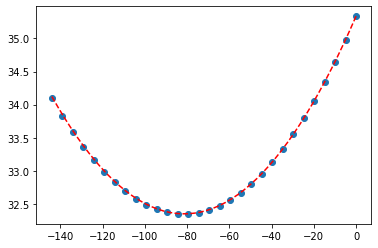

In [56]:
# нарисуем
xx = np.linspace(st_p[0], end_p[0], 50)  # генерим массив х в 50 штук
a = 1108.12
dx = -81.32

def z(f):
    zz = []
    for i in f:
        zz.append(a*math.cosh((i-dx)/a)-a+32.35)
    return zz

plt.plot(ts_appr_r[:,0], ts_appr_r[:,1], 'o')
plt.plot(xx, z(xx), 'r--')


в итоге таков метод расчета аппроксимации, но есть одно условие - мы должны знать высоту нижней точки провода - от этого зависит итоговая точность аппроксимации

в будущем желательно доработать так чтобы небыло зависимости от нижней точки и можно было строить кривую по двум ТК и одной точки на проводе